<a href="https://colab.research.google.com/github/riyadk-chan/depth-estimation-test/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q torch torchvision transformers opencv-python matplotlib pillow

## Imports

In [3]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import pipeline

In [4]:
# Vérifier GPU
device = 0 if torch.cuda.is_available() else -1
print(f"Device: {'GPU' if device == 0 else 'CPU'}")

Device: GPU


## Charger le modèle

In [5]:
# Depth Anything V2 Base
print("Chargement de Depth Anything V2 Base...")
depth_estimator = pipeline(
    task="depth-estimation",
    model="depth-anything/Depth-Anything-V2-Base-hf",
    device=device
)
print("Modèle chargé!")

Chargement de Depth Anything V2 Base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


Modèle chargé!


## Test et comparaisons RGB grayscale

In [11]:
def test_depth_estimation_comparison(image_path_or_pil):
    """
    Teste l'estimation de profondeur sur RGB ET Grayscale
    """
    import time

    # Charger l'image ORIGINALE (RGB)
    if isinstance(image_path_or_pil, str):
        image_rgb = Image.open(image_path_or_pil)
    else:
        image_rgb = image_path_or_pil

    # Convertir en grayscale
    image_gray = image_rgb.convert('L')

    # Convertir grayscale → RGB (dupliquer canal)
    gray_np = np.array(image_gray)
    gray_to_rgb = np.stack([gray_np, gray_np, gray_np], axis=-1)
    gray_rgb_image = Image.fromarray(gray_to_rgb)

    # ============================================
    # ANALYSE 1 : Image RGB Originale
    # ============================================
    print("="*60)
    print("ANALYSE 1 : IMAGE RGB ORIGINALE")
    print("="*60)

    start = time.time()
    result_rgb = depth_estimator(image_rgb)
    elapsed_rgb = time.time() - start
    depth_map_rgb = np.array(result_rgb['depth'])

    print(f" Traitement RGB terminé en {elapsed_rgb:.2f}s")
    print(f"   Min depth: {depth_map_rgb.min():.2f}")
    print(f"   Max depth: {depth_map_rgb.max():.2f}")
    print(f"   Mean depth: {depth_map_rgb.mean():.2f}")

    # ============================================
    # ANALYSE 2 : Image Grayscale
    # ============================================
    print("\n" + "="*60)
    print("ANALYSE 2 : IMAGE GRAYSCALE")
    print("="*60)

    start = time.time()
    result_gray = depth_estimator(gray_rgb_image)
    elapsed_gray = time.time() - start
    depth_map_gray = np.array(result_gray['depth'])

    print(f" Traitement Grayscale terminé en {elapsed_gray:.2f}s")
    print(f"   Min depth: {depth_map_gray.min():.2f}")
    print(f"   Max depth: {depth_map_gray.max():.2f}")
    print(f"   Mean depth: {depth_map_gray.mean():.2f}")

    # ============================================
    # VISUALISATION COMPARATIVE (2 lignes)
    # ============================================
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # LIGNE 1 : RGB
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title('Image Originale (RGB)', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(depth_map_rgb, cmap='plasma')
    axes[0, 1].set_title('Depth Map (RGB)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    depth_norm_rgb = (depth_map_rgb - depth_map_rgb.min()) / (depth_map_rgb.max() - depth_map_rgb.min())
    axes[0, 2].imshow(depth_norm_rgb, cmap='viridis')
    axes[0, 2].set_title('Profondeur Normalisée (RGB)', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    axes[0, 3].text(0.5, 0.5, f'Temps: {elapsed_rgb:.2f}s\nMin: {depth_map_rgb.min():.2f}\nMax: {depth_map_rgb.max():.2f}\nMean: {depth_map_rgb.mean():.2f}',
                    ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[0, 3].set_title('Métriques RGB', fontsize=12, fontweight='bold')
    axes[0, 3].axis('off')

    # LIGNE 2 : GRAYSCALE
    axes[1, 0].imshow(image_gray, cmap='gray')
    axes[1, 0].set_title('Image Grayscale', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(depth_map_gray, cmap='plasma')
    axes[1, 1].set_title('Depth Map (Grayscale)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    depth_norm_gray = (depth_map_gray - depth_map_gray.min()) / (depth_map_gray.max() - depth_map_gray.min())
    axes[1, 2].imshow(depth_norm_gray, cmap='viridis')
    axes[1, 2].set_title('Profondeur Normalisée (Grayscale)', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')

    axes[1, 3].text(0.5, 0.5, f'Temps: {elapsed_gray:.2f}s\nMin: {depth_map_gray.min():.2f}\nMax: {depth_map_gray.max():.2f}\nMean: {depth_map_gray.mean():.2f}',
                    ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 3].set_title('Métriques Grayscale', fontsize=12, fontweight='bold')
    axes[1, 3].axis('off')

    plt.suptitle('COMPARAISON RGB vs GRAYSCALE', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    # ============================================
    # ANALYSE COMPARATIVE
    # ============================================
    print("\n" + "="*60)
    print("ANALYSE COMPARATIVE")
    print("="*60)

    diff_time = abs(elapsed_rgb - elapsed_gray)
    diff_mean = abs(depth_map_rgb.mean() - depth_map_gray.mean())

    print(f"Différence de temps:     {diff_time:.2f}s ({diff_time/elapsed_rgb*100:.1f}%)")
    print(f"Différence de profondeur moyenne: {diff_mean:.2f}")

    if diff_mean < 5:
        print("Les deux méthodes donnent des résultats très similaires!")
    elif diff_mean < 15:
        print("Différence modérée entre RGB et Grayscale")
    else:
        print("Différence significative - RGB semble mieux capter la profondeur")

    return {
        'rgb': {'depth': depth_map_rgb, 'time': elapsed_rgb},
        'gray': {'depth': depth_map_gray, 'time': elapsed_gray}
    }


ANALYSE 1 : IMAGE RGB ORIGINALE
 Traitement RGB terminé en 0.39s
   Min depth: 0.00
   Max depth: 255.00
   Mean depth: 95.69

ANALYSE 2 : IMAGE GRAYSCALE
 Traitement Grayscale terminé en 0.27s
   Min depth: 0.00
   Max depth: 255.00
   Mean depth: 96.05


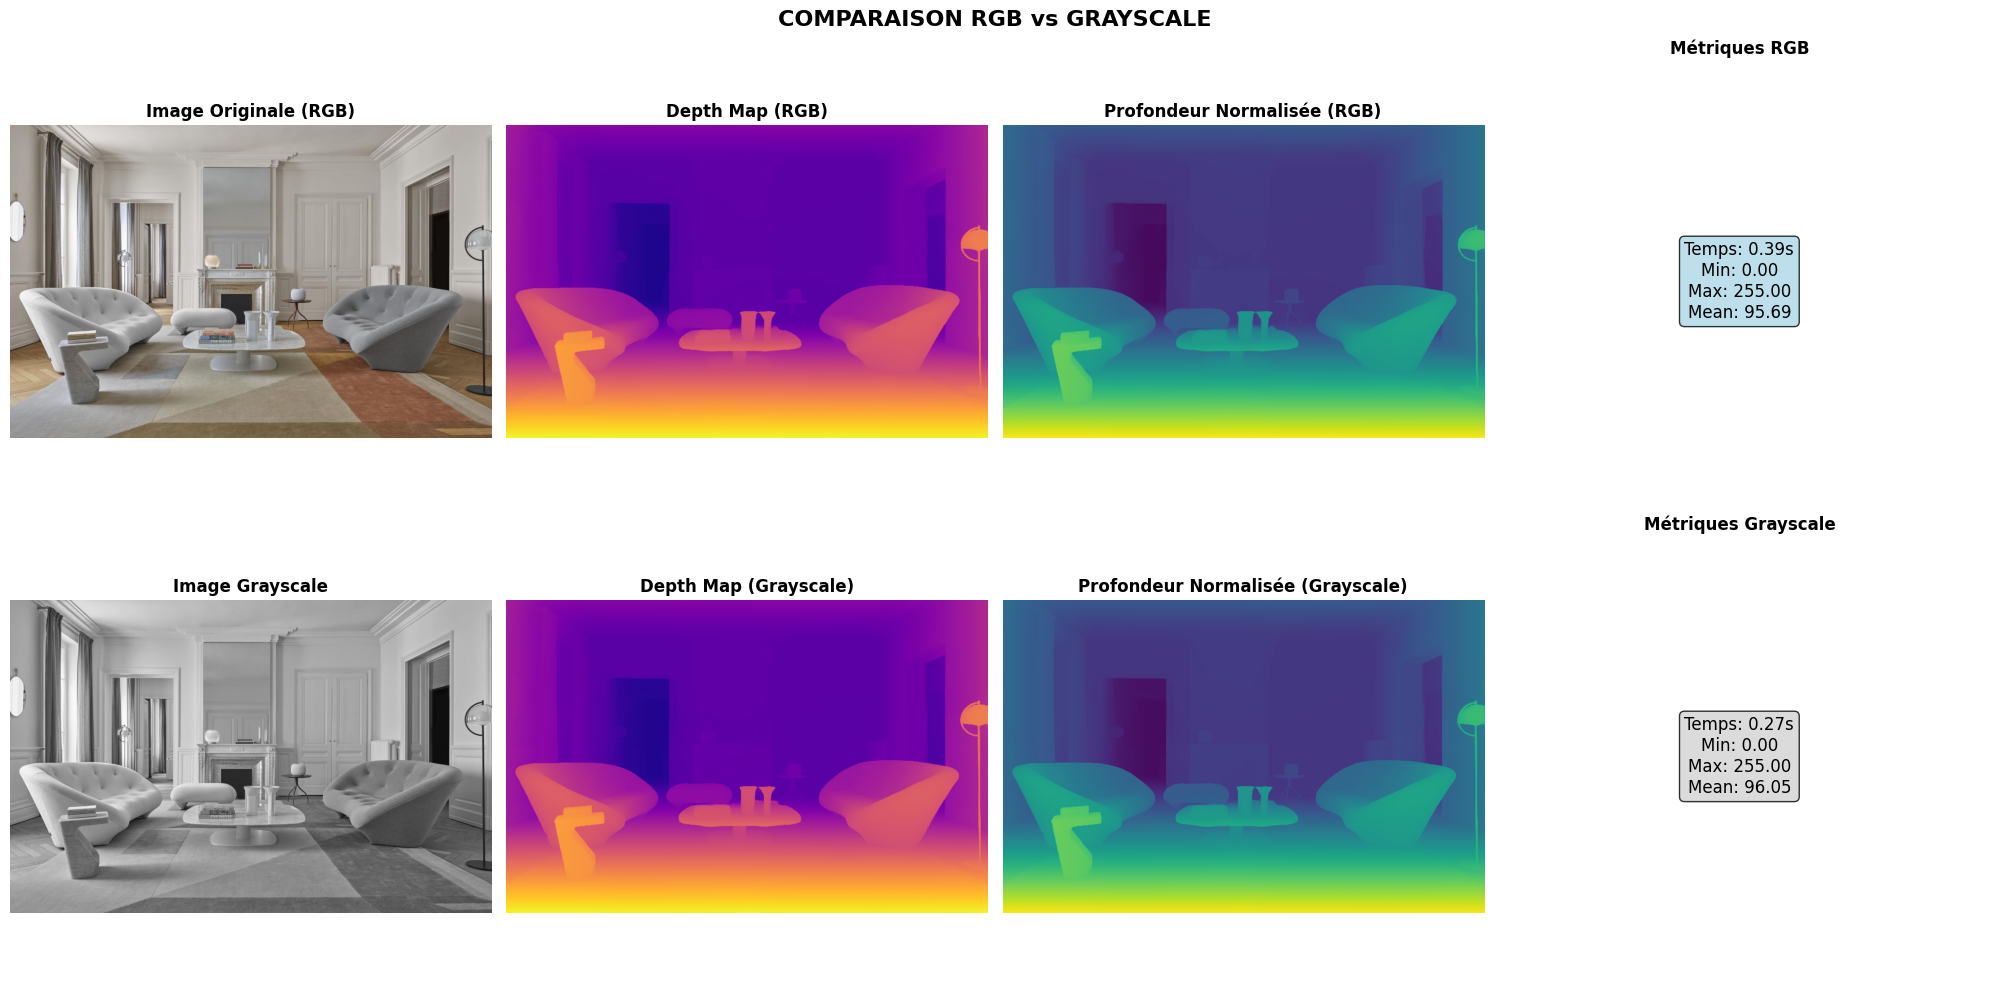


ANALYSE COMPARATIVE
Différence de temps:     0.11s (28.9%)
Différence de profondeur moyenne: 0.36
Les deux méthodes donnent des résultats très similaires!


{'rgb': {'depth': array([[ 91,  91,  90, ...,  93,  88,  85],
         [ 91,  91,  90, ...,  94,  90,  88],
         [ 91,  90,  90, ...,  96,  94,  93],
         ...,
         [253, 253, 253, ..., 253, 253, 253],
         [254, 253, 253, ..., 254, 254, 254],
         [254, 254, 253, ..., 254, 254, 255]], dtype=uint8),
  'time': 0.3850677013397217},
 'gray': {'depth': array([[ 92,  92,  92, ...,  95,  90,  87],
         [ 92,  92,  91, ...,  96,  92,  90],
         [ 92,  92,  91, ...,  98,  96,  95],
         ...,
         [253, 253, 252, ..., 253, 253, 253],
         [253, 253, 253, ..., 253, 254, 254],
         [254, 253, 253, ..., 254, 254, 255]], dtype=uint8),
  'time': 0.27396655082702637}}

In [12]:
test_depth_estimation_comparison("/content/image_test.jpg")

ANALYSE 1 : IMAGE RGB ORIGINALE
 Traitement RGB terminé en 0.45s
   Min depth: 0.00
   Max depth: 255.00
   Mean depth: 130.07

ANALYSE 2 : IMAGE GRAYSCALE
 Traitement Grayscale terminé en 0.32s
   Min depth: 0.00
   Max depth: 255.00
   Mean depth: 127.39


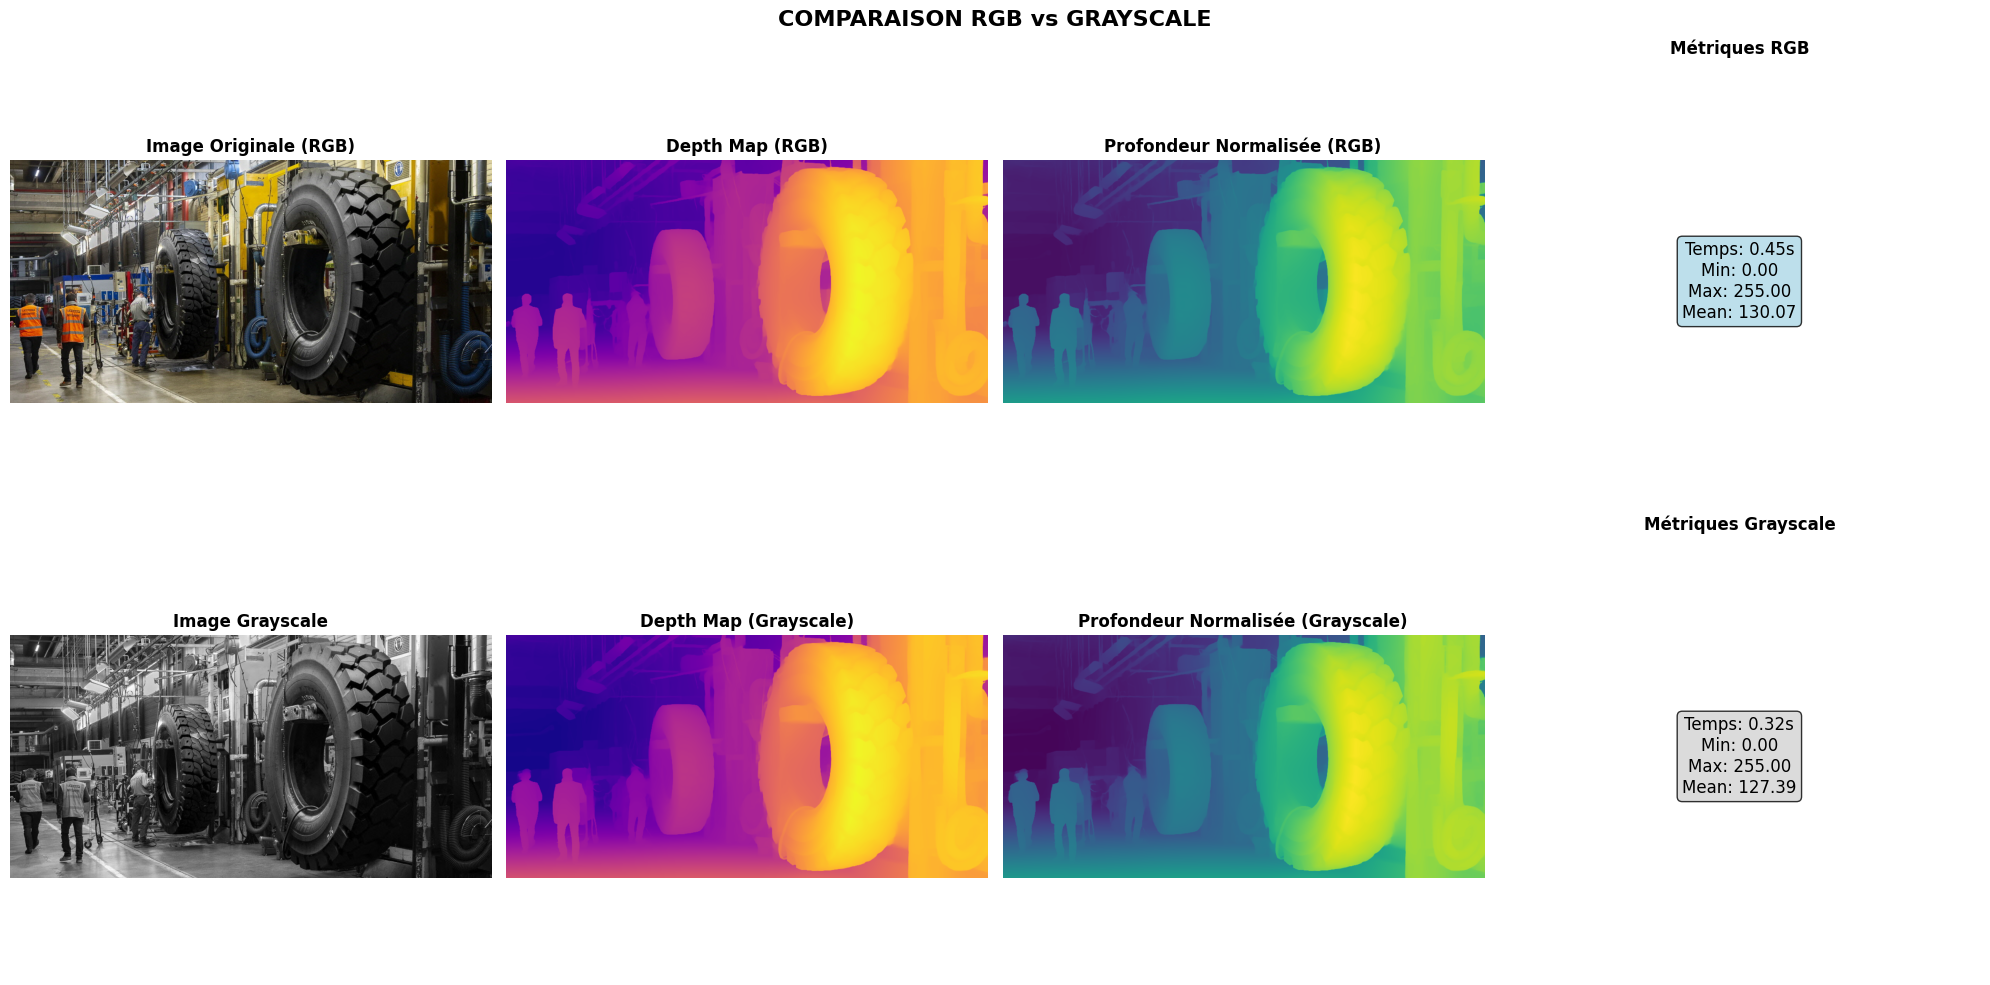


ANALYSE COMPARATIVE
Différence de temps:     0.13s (28.3%)
Différence de profondeur moyenne: 2.68
Les deux méthodes donnent des résultats très similaires!


{'rgb': {'depth': array([[ 29,  29,  29, ...,  71,  70,  70],
         [ 29,  29,  29, ...,  73,  72,  73],
         [ 29,  29,  29, ...,  73,  73,  74],
         ...,
         [138, 138, 138, ..., 191, 191, 191],
         [140, 139, 139, ..., 192, 192, 191],
         [141, 140, 139, ..., 192, 192, 192]], dtype=uint8),
  'time': 0.4496009349822998},
 'gray': {'depth': array([[ 27,  27,  27, ...,  76,  74,  73],
         [ 27,  27,  27, ...,  77,  76,  77],
         [ 27,  27,  27, ...,  78,  77,  78],
         ...,
         [134, 134, 134, ..., 199, 199, 199],
         [136, 135, 135, ..., 199, 200, 199],
         [137, 136, 136, ..., 200, 200, 200]], dtype=uint8),
  'time': 0.3221397399902344}}

In [9]:
test_depth_estimation_comparison("/content/image_test_2.jpg")